# Loan Default Prediction
## Step 5: Modeling (part 1)

## Table of Content
1. Overview (current notebook)
2. Imports and Data Loading
3. Logistic Regression (current notebook)
4. KNN (part 2)
5. Random Forest (part 3)
6. SVM (part 4)
7. Final Model Selection and Summary (part 5)

## 5.1 Overview

### Evaluation Metrics
The data is now ready for use in training models. But before training the models it is important to consider the evaluation metrics in the context of the problem. Without a reasonable evaluation metric, it would not be possible to track the progress of model training (underfitting or overfitting?) or select the most effective among various models. The goal of the model is to minimize loss by identifying probable defaults; therefore false negatives are of particular importance. Furthermore, the target class is imbalanced, so accuracy alone might not be a good metric. Some metrics to be considered are the confusion matrix (highlighting the recall or sensitivity), log loss and AUC-ROC.

### Candidate Algorithms
The baseline will be established by a logistic regression model (which could be best performing by all means!). Some other models to be tested are KNN, random forest, and SVM.

### Work Flow
For each model, we will need to
1. set the parameters
2. fit the training data
3. predict based on the testing data
4. score using the above-mentioned metrics

Each set of parameters will be tested using k-fold cross-validations. Furthermore, the tunings of the parameters will be explored with a grid or random search. Algorithm-appropriate visualizations will also be made.

## 5.2 Imports and Data Loading

In [1]:
# packages and libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Scikit learn

In [3]:
# load training data
path = '../data/'
filename = 'train_scaled.csv'

df = pd.read_csv(path+filename)
df.head()

,Unnamed: 0,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,credit_lines_outstanding_stan,loan_amt_outstanding_stan,total_debt_outstanding_stan,income_stan,years_employed_stan,fico_score_stan,credit_lines_outstanding_norm,loan_amt_outstanding_norm,total_debt_outstanding_norm,income_norm,years_employed_norm,fico_score_norm,default
0,906,0,3066.012991,4088.408910,62090.43416,3,619,-0.835937,-0.770267,-0.695067,-0.393287,-0.988435,-0.307341,0.0,0.281839,0.092392,0.414419,0.3,0.477376,0
1,8841,1,3615.966492,5520.055959,62090.71989,5,639,-0.263321,-0.383727,-0.479970,-0.393273,0.285204,0.019814,0.2,0.333234,0.125204,0.414421,0.5,0.522624,0
2,1644,3,5702.346570,15067.143560,77954.83237,3,524,0.881910,1.082706,0.954427,0.394981,-0.988435,-1.861325,0.6,0.528214,0.344015,0.522038,0.3,0.262443,1
3,1377,1,4224.598684,10228.911200,71962.47797,4,623,-0.263321,0.044056,0.227510,0.097234,-0.351615,-0.241910,0.2,0.390113,0.233127,0.481388,0.4,0.486425,0
4,8255,1,6982.214944,9115.623310,104349.15850,7,639,-0.263321,1.982274,0.060244,1.706460,1.558844,0.019814,0.2,0.647823,0.207611,0.701090,0.7,0.522624,0


## 5.3 Logistic Regression


### 5.3.1 Baseline Model

In [20]:
# use the features scaled by StandardScaler()
X = df.iloc[:,7:13]
y = df['default']

In [53]:
# build a logistic regressor with default parameters
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.1, random_state=23)
clf = LogisticRegression(random_state=23)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

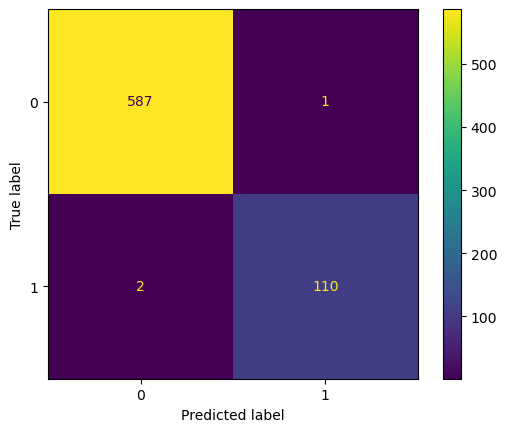

In [45]:
# visualize results with confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

The baseline model is performing reasonably well; we will produce results on some other metrics as well.

In [47]:
# classification report
from sklearn.metrics import classification_report

target_names = ['0(no default)', '1(default)']
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

0(no default)       1.00      1.00      1.00       588
   1(default)       0.99      0.98      0.99       112

     accuracy                           1.00       700
    macro avg       0.99      0.99      0.99       700
 weighted avg       1.00      1.00      1.00       700



In [56]:
# Brier score and log loss
from sklearn.metrics import brier_score_loss, log_loss

print('Brier score loss: \t' + str(brier_score_loss(y_test, y_proba)))
print('log loss: \t\t' + str(log_loss(y_test, y_proba)))

Brier score loss: 	0.003772891225423865
log loss: 		0.015680088351767384


ROC_AUC score:  0.9999696307094267


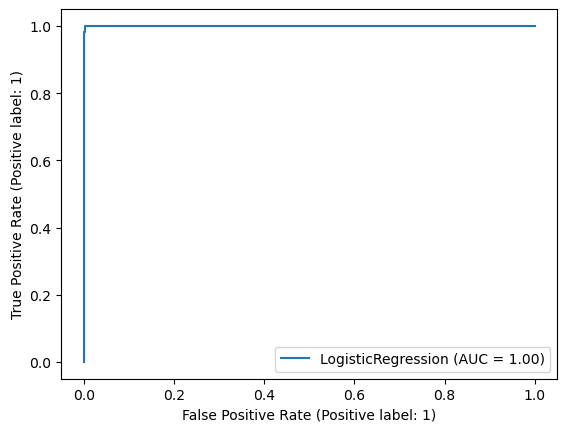

In [57]:
# AUC-ROC score and visualization
from sklearn.metrics import roc_auc_score, RocCurveDisplay

print('ROC_AUC score: ', str(roc_auc_score(y_test, y_proba)))
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.show()

In [ ]:
# for visualizing datapoints
'''
results = pd.DataFrame({'predicted':y_proba[:,1], 'actual':y_test})
sorted_results = results.sort_values(by='predicted').reset_index()

sns.scatterplot(x=sorted_results.index, y=sorted_results['predicted'])
sns.scatterplot(x=sorted_results.index, y=sorted_results['actual'])
plt.show()
'''

### 5.3.2 Fine-Tuning and Cross Validation

The model is performing well as is; but we will still experiment with the hyperparameters as well as perfoming k-fold validation.

In [ ]:

from sklearn.model_selection import RandomizedSearchCV

# build a classifier
clf = SGDClassifier(loss="hinge", penalty="elasticnet", fit_intercept=True)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {
    "average": [True, False],
    "l1_ratio": stats.uniform(0, 1),
    "alpha": stats.loguniform(1e-2, 1e0),
}

# run randomized search
n_iter_search = 15
random_search = RandomizedSearchCV(
    clf, param_distributions=param_dist, n_iter=n_iter_search
)

start = time()
random_search.fit(X, y)
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((time() - start), n_iter_search)
)
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {
    "average": [True, False],
    "l1_ratio": np.linspace(0, 1, num=10),
    "alpha": np.power(10, np.arange(-2, 1, dtype=float)),
}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings."
    % (time() - start, len(grid_search.cv_results_["params"]))
)
report(grid_search.cv_results_)
